In [1]:
#r "nuget: Newtonsoft.Json"
#r "nuget: FSharp.Control.AsyncSeq"

Installed Packages FSharp.Control.AsyncSeq, 3.2.1 Newtonsoft.Json, 13.0.4

In [2]:
open System
open System.Net.Http
open System.Net.WebSockets
open System.Threading
open System.Threading.Tasks
open System.Text
open Newtonsoft.Json
open Newtonsoft.Json.Linq
open Microsoft.DotNet.Interactive
open Microsoft.DotNet.Interactive.Formatting
open System.Collections.Generic
open FSharp.Control

let serverAddress = "127.0.0.1:8000"
let clientId = Guid.NewGuid().ToString()
let httpClient = new HttpClient()

let queueWorkflow (workflow: JObject) (promptId: string) = task {
    let p = JObject()
    p.["prompt"] <- workflow
    p.["client_id"] <- clientId
    p.["prompt_id"] <- promptId
    
    let content = new StringContent(p.ToString(), Encoding.UTF8, "application/json")
    let! response = httpClient.PostAsync($"http://{serverAddress}/prompt", content)
    response.EnsureSuccessStatusCode() |> ignore
}

let getImage (filename: string) (subfolder: string) (folderType: string) = task {
    let query = $"filename={Uri.EscapeDataString(filename)}&subfolder={Uri.EscapeDataString(subfolder)}&type={Uri.EscapeDataString(folderType)}"
    let url = $"http://{serverAddress}/view?{query}"
    let! response = httpClient.GetAsync(url)
    return! response.Content.ReadAsByteArrayAsync()
}

let getHistory (promptId: string) = task {
    let! response = httpClient.GetAsync($"http://{serverAddress}/history/{promptId}")
    let! json = response.Content.ReadAsStringAsync()
    return JObject.Parse(json)
}

let receiveMessage (ws: ClientWebSocket) = task {
    let buffer = Array.zeroCreate<byte> 10240
    let segment = new ArraySegment<byte>(buffer)
    let sb = StringBuilder()
    
    let rec read () = task {
        let! result = ws.ReceiveAsync(segment, CancellationToken.None)
        let chunk = Encoding.UTF8.GetString(buffer, 0, result.Count)
        sb.Append(chunk) |> ignore
        if result.EndOfMessage then
            if result.MessageType = WebSocketMessageType.Text then
                return Some (sb.ToString())
            else
                return None // Binary or Close
        else
            return! read ()
    }

    return! read ()
}

let getImages (webSocket: ClientWebSocket) (workflow: JObject) = task {
    let runId = Guid.NewGuid().ToString()
    do! queueWorkflow workflow runId

    let messageStream = asyncSeq {
        while true do
            let! msg = receiveMessage webSocket |> Async.AwaitTask
            match msg with
            | Some m -> yield JObject.Parse m
            | None -> ()
    }

    let runIsExecuting runId (message: JObject) =
        if message.["type"].ToString() = "executing" then
            let data = message.["data"]
            if data.["node"].Type = JTokenType.Null && data.["prompt_id"].ToString() = runId then
                false
            else
                true
        else
            true

    do! 
        messageStream
        |> AsyncSeq.takeWhile (runIsExecuting runId)
        |> AsyncSeq.iter ignore
        
    let! history = getHistory runId
    let historyData = history.[runId]
    let outputs = historyData.["outputs"] :?> JObject
    
    let! outputImages =
        outputs.Properties()
        |> Seq.map (fun property -> task {
            let nodeId = property.Name
            let nodeOutput = property.Value
            if nodeOutput.["images"] <> null then
                let! images = 
                    nodeOutput.["images"]
                    |> Seq.map (fun img -> 
                        let filename = img.["filename"].ToString()
                        let subfolder = img.["subfolder"].ToString()
                        let folderType = img.["type"].ToString()
                        getImage filename subfolder folderType)
                    |> Task.WhenAll
                return nodeId, images
            else
                return nodeId, [||]
        })
        |> Task.WhenAll

    return outputImages |> Map.ofArray
}

In [3]:
let showImage imgBytes =
    let base64Img = Convert.ToBase64String imgBytes
    $"<img src=\"data:image/png;base64,{base64Img}\" />"
    |> HTML
    |> display
    |> ignore

let createWorkflow (wfJson: string) (seed: int64) (prompt: string) =
    let workflow = JObject.Parse wfJson
    workflow.["83:27"].["inputs"].["text"] <- prompt
    workflow.["83:3"].["inputs"].["seed"] <- seed
    workflow

let downloadImages (workflow: JObject) = task {
    use webSocket = new ClientWebSocket()
    do! webSocket.ConnectAsync(Uri($"ws://{serverAddress}/ws?clientId={clientId}"), CancellationToken.None)
    let! images = getImages webSocket workflow
    do! webSocket.CloseAsync(WebSocketCloseStatus.NormalClosure, "Done", CancellationToken.None)
    return images |> Seq.collect _.Value
}

In [4]:
let workflowJson = """
{
  "60": {
    "inputs": {
      "filename_prefix": "z-image-turbo",
      "images": [
        "83:8",
        0
      ]
    },
    "class_type": "SaveImage",
    "_meta": {
      "title": "Save Image"
    }
  },
  "83:13": {
    "inputs": {
      "width": 1024,
      "height": 1024,
      "batch_size": 1
    },
    "class_type": "EmptySD3LatentImage",
    "_meta": {
      "title": "EmptySD3LatentImage"
    }
  },
  "83:28": {
    "inputs": {
      "unet_name": "z_image_turbo_bf16.safetensors",
      "weight_dtype": "default"
    },
    "class_type": "UNETLoader",
    "_meta": {
      "title": "Load Diffusion Model"
    }
  },
  "83:27": {
    "inputs": {
      "text": "A bear and a lion getting high on marijuana and eating curry",
      "clip": [
        "83:30",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "83:33": {
    "inputs": {
      "conditioning": [
        "83:27",
        0
      ]
    },
    "class_type": "ConditioningZeroOut",
    "_meta": {
      "title": "ConditioningZeroOut"
    }
  },
  "83:30": {
    "inputs": {
      "clip_name": "qwen_3_4b.safetensors",
      "type": "lumina2",
      "device": "default"
    },
    "class_type": "CLIPLoader",
    "_meta": {
      "title": "Load CLIP"
    }
  },
  "83:3": {
    "inputs": {
      "seed": 1083768031008833,
      "steps": 4,
      "cfg": 1,
      "sampler_name": "res_multistep",
      "scheduler": "simple",
      "denoise": 1,
      "model": [
        "83:28",
        0
      ],
      "positive": [
        "83:27",
        0
      ],
      "negative": [
        "83:33",
        0
      ],
      "latent_image": [
        "83:13",
        0
      ]
    },
    "class_type": "KSampler",
    "_meta": {
      "title": "KSampler"
    }
  },
  "83:8": {
    "inputs": {
      "samples": [
        "83:3",
        0
      ],
      "vae": [
        "83:29",
        0
      ]
    },
    "class_type": "VAEDecode",
    "_meta": {
      "title": "VAE Decode"
    }
  },
  "83:29": {
    "inputs": {
      "vae_name": "ae.safetensors"
    },
    "class_type": "VAELoader",
    "_meta": {
      "title": "Load VAE"
    }
  }
}
"""


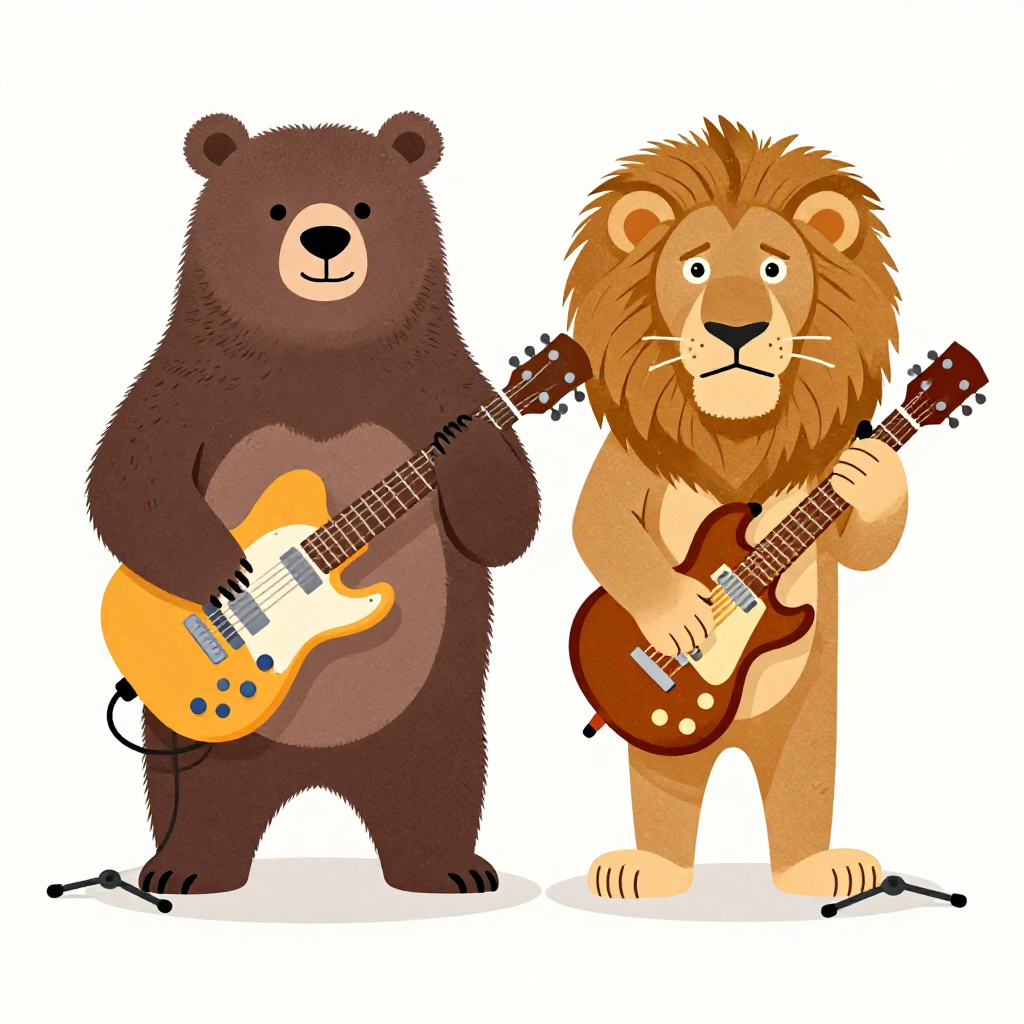

In [5]:
"A bear and a lion in a rock band" 
|> createWorkflow workflowJson DateTimeOffset.UtcNow.Ticks
|> downloadImages
|> Async.AwaitTask
|> Async.RunSynchronously
|> Seq.iter showImage